In [ ]:
# Instalações necessárias
!pip install prophet
!pip install streamlit

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.0 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.0 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.0 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.0 which is incompatible.
mizani 0.13.5 requires numpy>=1.23.5, but you have numpy 1.23.0 which is incompatible.
scipy 1.15.3 requires numpy<2.5,>=1.23.5, but you have numpy 1.23.0 wh

In [ ]:
# Importação do arquivo
# from google.colab import files

# uploaded = files.upload()

In [ ]:
# Leitura do arquivo e criação de df Pandas
import pandas as pd

df = pd.read_csv('Base_precos_brent_ipea.csv', sep=',', decimal=',')
df['data'] = pd.to_datetime(df['data'], dayfirst=True)
df = df.sort_values('data')

# Validação de nulos
print(df.isnull().sum())

data     0
preco    0
dtype: int64


In [ ]:
# Describe para identificação de métricas gerais

df.describe()

,data,preco
count,11415,11415.000000
mean,2006-12-28 20:11:02.286465024,53.533153
min,1987-05-20 00:00:00,9.100000
25%,1998-08-13 12:00:00,20.730000
50%,2007-07-30 00:00:00,49.410000
75%,2015-06-23 12:00:00,76.770000
max,2025-05-02 00:00:00,143.950000
std,NaN,33.056389


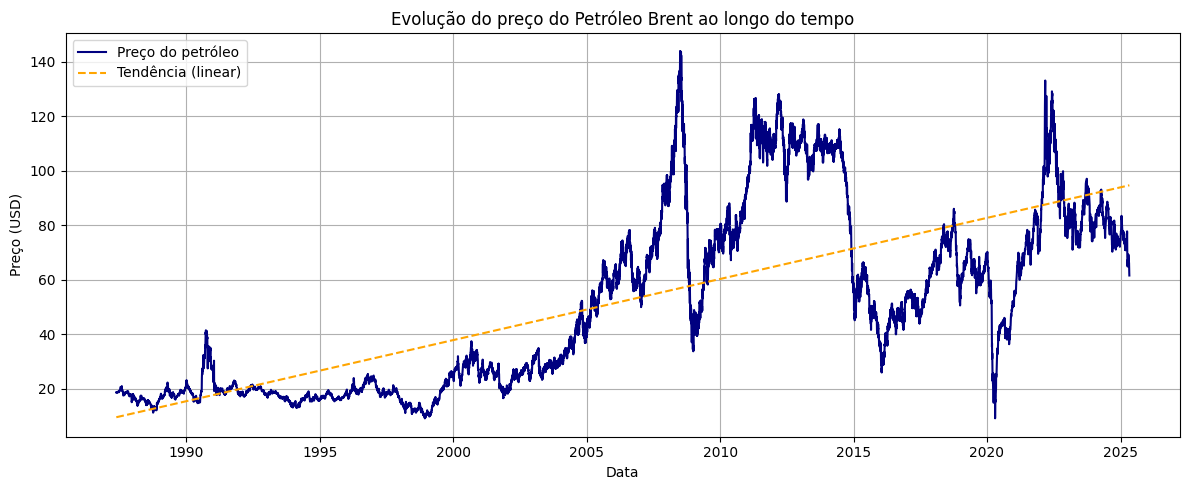

In [ ]:
# Plotagem de gráfico simples, com uma linha de tendência, para entender o comportamento inicial da evolução dos preços
import matplotlib.pyplot as plt
import numpy as np

df['data_num'] = df['data'].map(pd.Timestamp.toordinal)

# Regressão linear simples para gerar a linha de tendência
z = np.polyfit(df['data_num'], df['preco'], 1)
p = np.poly1d(z)

# Plot do gráfico
plt.figure(figsize=(12, 5))
plt.plot(df['data'], df['preco'], label='Preço do petróleo', color='navy')
plt.plot(df['data'], p(df['data_num']), label='Tendência (linear)', color='orange', linestyle='--')
plt.title('Evolução do preço do Petróleo Brent ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Decomposição da Série Temporal**

O gráfico inicial demonstra uma oscilação significativa nos valores ao longo do tempo, sendo importante isolarmos em séries temporais para termos um critério mais preciso de escolha do modelo que será aplicado posteriormente.

A decomposição de séries temporais nos permite separar a evolução dos preços do petróleo em componentes distintos: tendência, sazonalidade e ruído (resíduos).

Esta técnica é útil para identificar padrões estruturais no comportamento da série ao longo do tempo e entender se há sazonalidade significativa, além de facilitar análises e modelagens futuras, como previsões ou detecção de anomalias.

Utilizaremos o método STL (Seasonal-Trend decomposition using Loess), que é mais robusto e flexível que métodos clássicos, funcionando bem mesmo quando a sazonalidade não é perfeitamente estável ao longo do tempo.

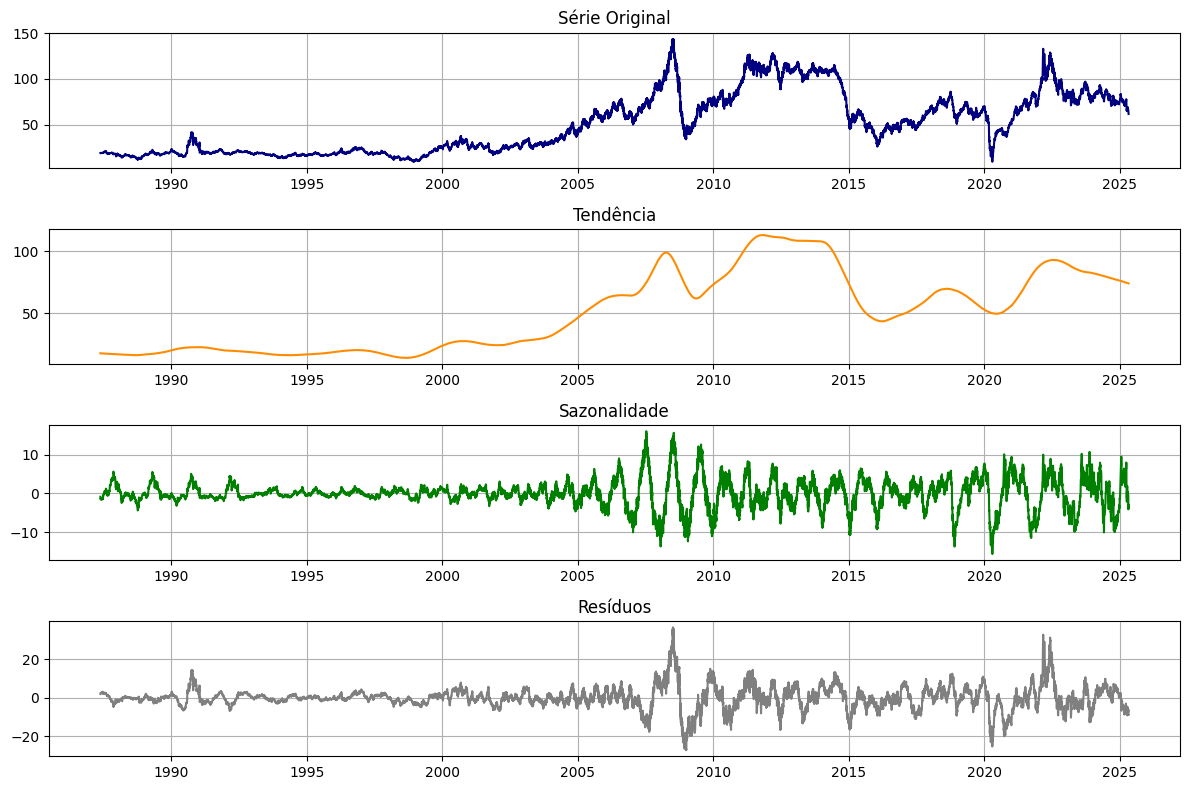

In [ ]:
from statsmodels.tsa.seasonal import STL

# Definindo a série temporal com índice de data
df_stl = df.set_index('data')
series = df_stl['preco']

# Aplicando o método STL
stl = STL(series, period=365)  # Para dados diários, assume-se possível sazonalidade anual
res = stl.fit()

# Plotando os componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(series, label='Original', color='navy')
plt.title('Série Original')
plt.grid(True)

plt.subplot(412)
plt.plot(res.trend, label='Tendência', color='darkorange')
plt.title('Tendência')
plt.grid(True)

plt.subplot(413)
plt.plot(res.seasonal, label='Sazonalidade', color='green')
plt.title('Sazonalidade')
plt.grid(True)

plt.subplot(414)
plt.plot(res.resid, label='Resíduos', color='gray')
plt.title('Resíduos')
plt.grid(True)

plt.tight_layout()
plt.show()


**Interpretação da Decomposição da Série Temporal dos Preços do Petróleo Brent**

O modelo utilizado para decomposição separa a série original em três componentes principais:

* **Tendência:** Representa o comportamento de longo prazo dos preços. Podemos observar um crescimento acentuado nos preços entre os anos de 2003 e 2008, seguido por forte queda com a crise financeira global (Crash de 2008). Há outras flutuações notáveis ao longo do tempo, como os efeitos da pandemia em 2020.

* **Sazonalidade:** Indica variações que se repetem periodicamente. No caso do petróleo, não há uma sazonalidade muito clara ou consistente como em séries de vendas ou temperatura, mas é possível perceber oscilações anuais de pequena magnitude que podem estar ligadas à demanda energética ou ciclos econômicos.

* **Resíduos:** Representam as variações não explicadas pela tendência nem pela sazonalidade. Aqui ficam evidentes choques pontuais e eventos inesperados (como guerras, crises políticas ou mudanças bruscas no mercado, a serem avaliados posteriormente). As maiores oscilações residuais estão concentradas nos períodos de crise, como em 2008 e 2020.

Esta decomposição é fundamental para compreender a estrutura do comportamento dos preços do petróleo ao longo do tempo. Com essa compreensão, conseguimos seguir para análises mais robustas, como a modelagem preditiva e a detecção de anomalias.

## Avaliação de Modelos Preditivos

Para aumentar a robustez da análise e justificar a escolha do modelo final, serão testadas três abordagens distintas de previsão:

1. **Prophet**

2. **SARIMAX**

3. **LSTM**

Cada modelo será avaliado pela sua capacidade de prever os preços dos próximos 6 meses, com base no histórico desde 2020. A métrica de avaliação será o **MAPE (Mean Absolute Percentage Error)**.


# Prophet

In [ ]:
from prophet import Prophet

df_prophet = df[df['data'] >= '2020-01-01'][['data', 'preco']].rename(columns={'data': 'ds', 'preco': 'y'})

modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet)

# Prevendo 180 dias (6 meses)
future = modelo_prophet.make_future_dataframe(periods=180)
forecast_prophet = modelo_prophet.predict(future)

# Avaliação
from sklearn.metrics import mean_absolute_percentage_error

# Remover nulos e alinhar previsões com dados reais
df_merge = df_prophet.set_index('ds').join(forecast_prophet.set_index('ds')[['yhat']], how='inner')
mape_prophet = mean_absolute_percentage_error(df_merge['y'], df_merge['yhat']) * 100

print(f"MAPE - Prophet: {mape_prophet:.2f}%")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5v7bknq2/146_4d46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5v7bknq2/awarmcjf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89668', 'data', 'file=/tmp/tmp5v7bknq2/146_4d46.json', 'init=/tmp/tmp5v7bknq2/awarmcjf.json', 'output', 'file=/tmp/tmp5v7bknq2/prophet_model8a63xl9a/prophet_model-20250515164200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE - Prophet: 7.04%


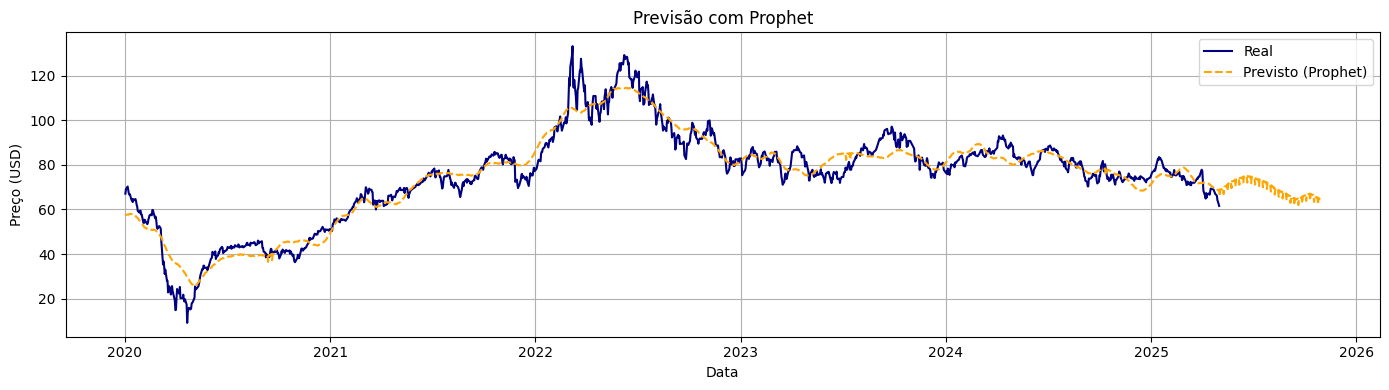

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Real', color='navy')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Previsto (Prophet)', color='orange', linestyle='--')
plt.title('Previsão com Prophet')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Filtra a série desde 2020
serie_sarimax = df[df['data'] >= '2020-01-01'].copy()
serie_sarimax.set_index('data', inplace=True)

# Ajusta o modelo SARIMAX (equivalente ao ARIMA(1,1,1))
modelo_sarimax = SARIMAX(serie_sarimax['preco'], order=(1, 1, 1))
resultado = modelo_sarimax.fit(disp=False)

# Previsão de 180 dias (6 meses)
previsao = resultado.get_forecast(steps=180)
media_prevista = previsao.predicted_mean
intervalo_confianca = previsao.conf_int()

# Criar datas futuras
datas_futuras = pd.date_range(start=serie_sarimax.index.max() + pd.Timedelta(days=1), periods=180)

# Criar DataFrame com previsão
df_previsao_sarimax = pd.DataFrame({
    'data': datas_futuras,
    'preco_previsto': media_prevista.values,
    'ic_lower': intervalo_confianca.iloc[:, 0].values,
    'ic_upper': intervalo_confianca.iloc[:, 1].values
})

# Avaliação (MAPE em cima da própria série usada)
previsao_treino = resultado.fittedvalues
mape_sarimax = mean_absolute_percentage_error(serie_sarimax['preco'].iloc[1:], previsao_treino.iloc[1:]) * 100

print(f"MAPE - SARIMAX: {mape_sarimax:.2f}%")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MAPE - SARIMAX: 2.04%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



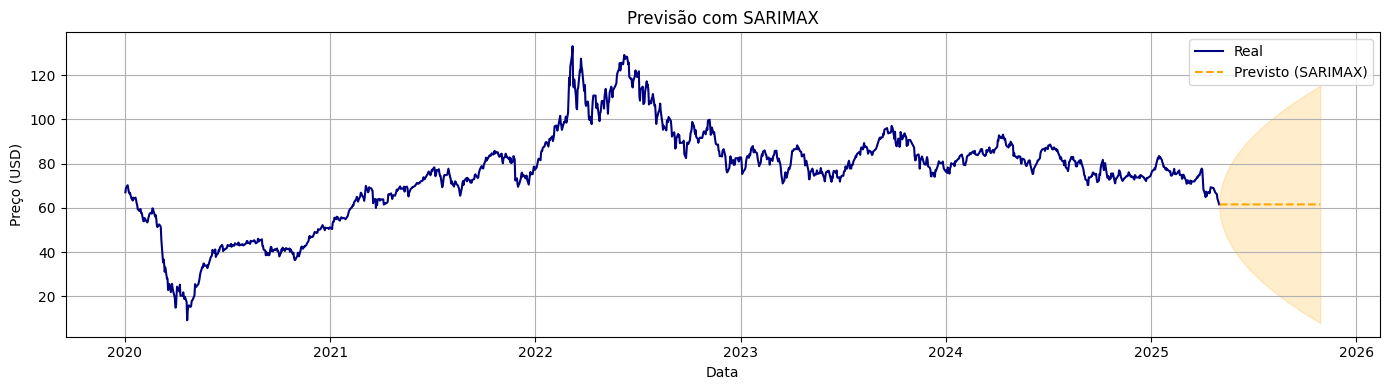

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(serie_sarimax.index, serie_sarimax['preco'], label='Real', color='navy')
plt.plot(df_previsao_sarimax['data'], df_previsao_sarimax['preco_previsto'], label='Previsto (SARIMAX)', color='orange', linestyle='--')
plt.fill_between(df_previsao_sarimax['data'], df_previsao_sarimax['ic_lower'], df_previsao_sarimax['ic_upper'], alpha=0.2, color='orange')
plt.title('Previsão com SARIMAX')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Série diária desde 2020
serie_lstm = df[df['data'] >= '2020-01-01'].copy()
serie_lstm.set_index('data', inplace=True)

# Normalização
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie_lstm['preco'].values.reshape(-1, 1))

# Preparando dados em janelas (X: t-30 → y: t)
def criar_sequencia(dados, janela):
    X, y = [], []
    for i in range(janela, len(dados)):
        X.append(dados[i-janela:i])
        y.append(dados[i])
    return np.array(X), np.array(y)

janela = 30
X, y = criar_sequencia(serie_scaled, janela)

# Dividindo em treino/teste
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(janela, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinamento
model.fit(X_train, y_train, epochs=10, verbose=0)

# Previsão
y_pred = model.predict(X_test)
y_pred_invertido = scaler.inverse_transform(y_pred)
y_test_invertido = scaler.inverse_transform(y_test)

# MAPE
mape_lstm = mean_absolute_percentage_error(y_test_invertido, y_pred_invertido) * 100
print(f"MAPE - LSTM: {mape_lstm:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAPE - LSTM: 2.73%


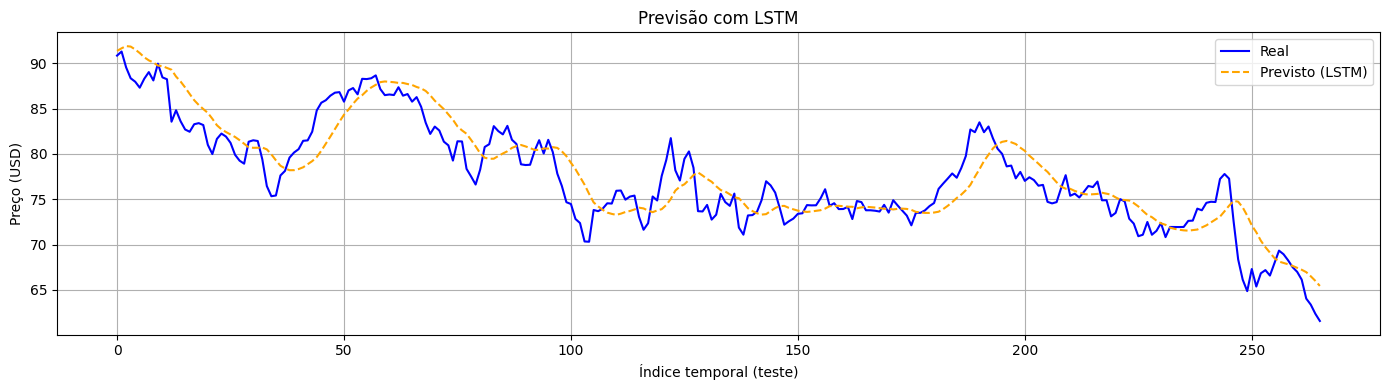

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(range(len(y_test_invertido)), y_test_invertido, label='Real', color='blue')
plt.plot(range(len(y_pred_invertido)), y_pred_invertido, label='Previsto (LSTM)', color='orange', linestyle='--')
plt.title('Previsão com LSTM')
plt.xlabel('Índice temporal (teste)')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Comparativo de MAPE entre os modelos:

SARIMAX: 2.04%
LSTM: 2.73%
Prophet: 7.04%


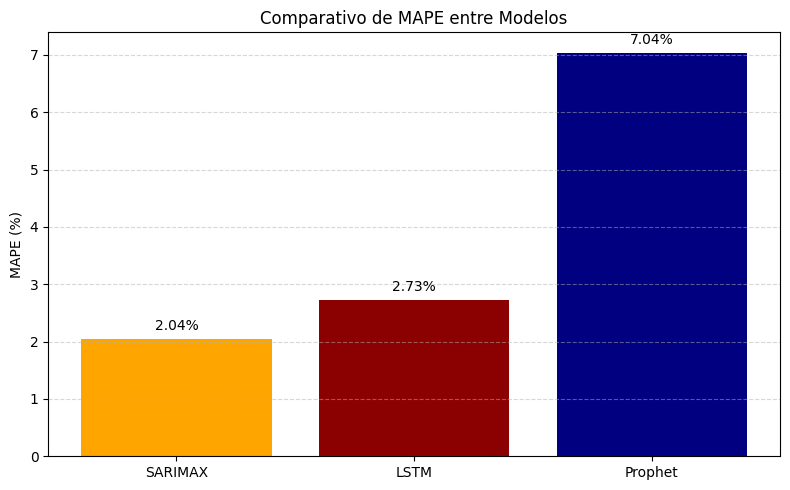

In [ ]:
# Resultados
mape_resultados = {
    'Prophet': mape_prophet,
    'SARIMAX': mape_sarimax,
    'LSTM': mape_lstm
}

# Ordenar por melhor desempenho
mape_ordenado = dict(sorted(mape_resultados.items(), key=lambda item: item[1]))

# Exibir no terminal
print("Comparativo de MAPE entre os modelos:\n")
for modelo, mape in mape_ordenado.items():
    print(f"{modelo}: {mape:.2f}%")

# Cores personalizadas
cores = {
    'Prophet': 'navy',
    'SARIMAX': 'orange',
    'LSTM': 'darkred'
}

# Gráfico de barras
plt.figure(figsize=(8, 5))
modelos = list(mape_ordenado.keys())
valores = list(mape_ordenado.values())
barras = plt.bar(modelos, valores, color=[cores[modelo] for modelo in modelos])

# Value labels no topo
for barra, valor in zip(barras, valores):
    plt.text(barra.get_x() + barra.get_width()/2, valor + 0.1, f"{valor:.2f}%", ha='center', va='bottom', fontsize=10)

plt.title('Comparativo de MAPE entre Modelos')
plt.ylabel('MAPE (%)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Escolha do Modelo Final de Previsão

Após a avaliação dos três modelos aplicados à série temporal dos preços do petróleo Brent — **Prophet**, **SARIMAX** e **LSTM** — utilizamos o **MAPE (Mean Absolute Percentage Error)** como métrica para medir a acurácia de cada abordagem. Os resultados foram:

- **SARIMAX**: 2,04%  
- **LSTM**: 2,73%  
- **Prophet**: 7,04%

O modelo **SARIMAX** apresentou o melhor desempenho, com o menor erro percentual médio. Além de mais preciso, oferece excelente **capacidade de interpretação estatística**, sendo amplamente utilizado em contextos econômicos e financeiros. Também se mostrou robusto frente à volatilidade da série histórica.

Apesar do bom desempenho do modelo **LSTM**, sua complexidade estrutural e menor interpretabilidade o tornam menos indicado para um projeto com foco analítico e de storytelling. Já o modelo **Prophet**, embora bastante prático e automatizado, suavizou demais oscilações relevantes, o que comprometeu sua precisão nesta base.

### ✅ Conclusão:

**O modelo escolhido para previsão final foi o SARIMAX**, por oferecer o melhor equilíbrio entre desempenho, simplicidade de aplicação e clareza interpretativa.


In [ ]:
%%writefile streamlit_app.py

Writing streamlit_app.py
